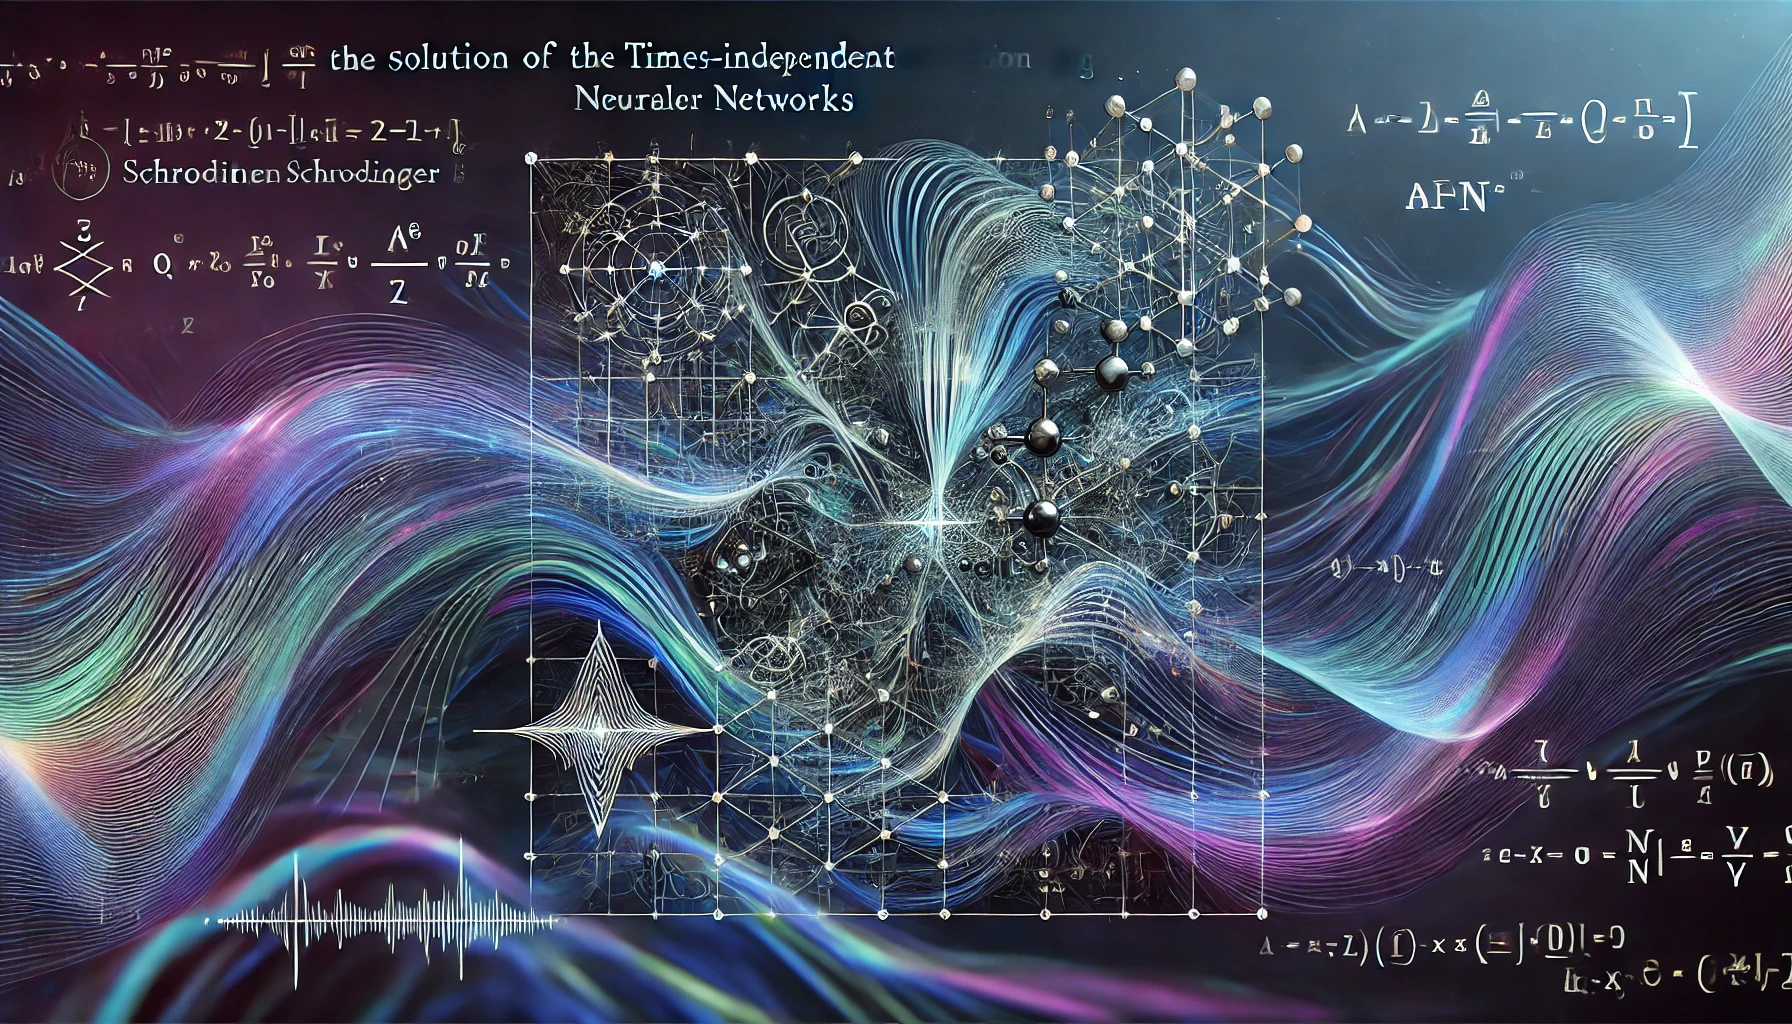

In [25]:
import tensorflow as tf
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [2]:
# Constants
hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
m = 9.10938356e-31    # Mass of electron (kg)
L = 1e-10             # Length of the potential well (meters)

In [3]:
# Neural Network definition
class SchrodingerPINN(tf.keras.Model):
    def __init__(self):
        super(SchrodingerPINN, self).__init__()
        self.hidden = tf.keras.layers.Dense(20, activation='tanh')
        self.out = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden(x)
        return self.out(x)

In [20]:
# Physics-Informed Loss Function
def loss_function(model, x):
    # Define the energy E
    E = 1.0

    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            tape.watch(x)
            tape2.watch(x)
            psi = model(x)
        dpsi_dx = tape.gradient(psi, x)
    d2psi_dx2 = tape2.gradient(dpsi_dx, x)

    # Schrödinger equation residual
    residual = -hbar**2 / (2 * m) * d2psi_dx2 + V(x) * psi - E * psi

    # Boundary conditions
    bc_loss = model(tf.constant([[0.0]], dtype=tf.float32))**2 + model(tf.constant([[L]], dtype=tf.float32))**2

    return tf.reduce_mean(residual**2) + bc_loss

In [21]:
# Potential function V(x)
def V(x):
    return 0.0

In [22]:
# Training the model
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = loss_function(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [23]:
# Create and train the PINN model
model = SchrodingerPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [26]:
loss_history = []

# Training loop
for epoch in range(1000):
    x = tf.random.uniform((100, 1), 0, L)
    loss = train_step(model, x, optimizer)
    loss_history.append(loss.numpy())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

Epoch 0, Loss: [[0.]]
Epoch 100, Loss: [[0.]]
Epoch 200, Loss: [[0.]]
Epoch 300, Loss: [[0.]]
Epoch 400, Loss: [[0.]]
Epoch 500, Loss: [[0.]]
Epoch 600, Loss: [[0.]]
Epoch 700, Loss: [[0.]]
Epoch 800, Loss: [[0.]]
Epoch 900, Loss: [[0.]]


Epoch 0, Loss: [[3.0312024e-23]]
Epoch 100, Loss: [[6.256241e-08]]
Epoch 200, Loss: [[1.027975e-12]]
Epoch 300, Loss: [[2.2404021e-17]]
Epoch 400, Loss: [[2.1175824e-21]]
Epoch 500, Loss: [[2.1175824e-22]]
Epoch 600, Loss: [[4.2351647e-22]]
Epoch 700, Loss: [[4.2351647e-22]]
Epoch 800, Loss: [[4.2351647e-22]]
Epoch 900, Loss: [[4.2351647e-22]]


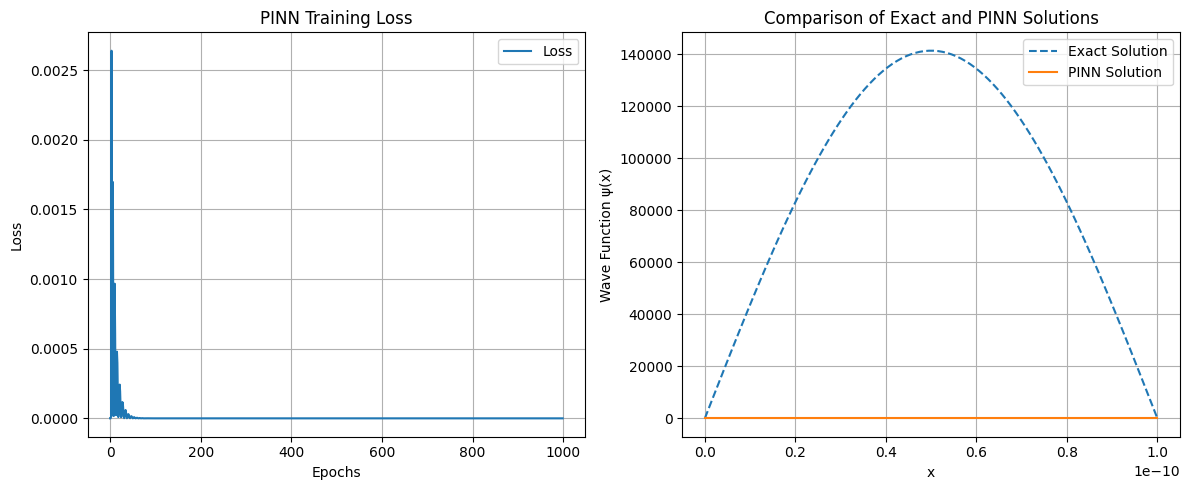

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Constants
hbar = 1.0545718e-34  # Reduced Planck constant (J·s)
m = 9.10938356e-31    # Mass of electron (kg)
L = 1e-10             # Length of the potential well (meters)
n = 1                 # Quantum number for exact solution

# Exact solution for the wave function
def exact_solution(x, n=1):
    return np.sqrt(2 / L) * np.sin(n * np.pi * x / L)

# Neural Network definition
class SchrodingerPINN(tf.keras.Model):
    def __init__(self):
        super(SchrodingerPINN, self).__init__()
        self.hidden = tf.keras.layers.Dense(20, activation='tanh')
        self.out = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden(x)
        return self.out(x)

# Physics-Informed Loss Function
def loss_function(model, x):
    # Define the energy E
    E = (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)

    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            tape.watch(x)
            tape2.watch(x)
            psi = model(x)
        dpsi_dx = tape.gradient(psi, x)
    d2psi_dx2 = tape2.gradient(dpsi_dx, x)

    # Schrödinger equation residual
    residual = -hbar**2 / (2 * m) * d2psi_dx2 + V(x) * psi - E * psi

    # Boundary conditions
    bc_loss = model(tf.constant([[0.]], dtype=tf.float32))**2 + model(tf.constant([[L]], dtype=tf.float32))**2

    return tf.reduce_mean(residual**2) + bc_loss

# Potential function V(x)
def V(x):
    return 0.0

# Training the model
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = loss_function(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Create and train the PINN model
model = SchrodingerPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Store losses for plotting
loss_history = []

# Training loop
epochs = 1000
for epoch in range(epochs):
    x = tf.random.uniform((100, 1), 0, L)
    loss = train_step(model, x, optimizer)
    loss_history.append(loss.numpy())  # Store the loss

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Generate predictions with the trained model
x_values = np.linspace(0, L, 100)
x_tf = tf.convert_to_tensor(x_values.reshape(-1, 1), dtype=tf.float32)
pinn_solution = model(x_tf).numpy().flatten()

# Calculate the exact solution
exact_sol = exact_solution(x_values, n)

# Plotting the loss history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), np.array(loss_history).flatten(), label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PINN Training Loss')
plt.legend()
plt.grid(True)

# Plotting the exact and PINN solutions
plt.subplot(1, 2, 2)
plt.plot(x_values, exact_sol, label='Exact Solution', linestyle='--')
plt.plot(x_values, pinn_solution, label='PINN Solution', linestyle='-')
plt.xlabel('x')
plt.ylabel('Wave Function ψ(x)')
plt.title('Comparison of Exact and PINN Solutions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()